<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

     |████████████████████████████████| 112kB 4.3MB/s 
     |████████████████████████████████| 634kB 10.6MB/s 
     |████████████████████████████████| 11.6MB 353kB/s 
     |████████████████████████████████| 9.5MB 40.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 71kB 3.1MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 184kB 17.7MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6638852 sha256=69205eab606a424b07e8a6e872899c6a908434889fe45e2d31f854e4152b6d68
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
     |████████████████████████████████| 5.7MB 3.9MB/s 
     |████████████████████████████████| 22.3MB 1.3MB/s 
     |████████████████████████████████| 102kB 4.6MB/s 
     |████████████████████████████████| 1.5MB 38.3MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Installing build dependencie

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



Я использую [данные о количестве продаж французского шампанского](https://www.kaggle.com/piyushagni5/monthly-sales-of-french-champagne) по месяцам и 
суточные [данные по климату](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data) в Дели, для простоты загрузки в колаб я залил датасеты на дропбокс

In [ ]:
# скачаем данные
!wget https://www.dropbox.com/s/mp9j6q8ejwmrpcn/champagne.zip
!wget https://www.dropbox.com/s/y440b0d52jjrb3c/climatedata.zip
!unzip champagne.zip
!unzip climatedata.zip

--2021-06-12 15:33:49--  https://www.dropbox.com/s/mp9j6q8ejwmrpcn/champagne.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mp9j6q8ejwmrpcn/champagne.zip [following]
--2021-06-12 15:33:49--  https://www.dropbox.com/s/raw/mp9j6q8ejwmrpcn/champagne.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb48aea1083b0d9bcc6ec38cc22.dl.dropboxusercontent.com/cd/0/inline/BQTBV_0zgqSce9NTAYzfhhQI-Y247VNM7SkroLokBrLCgteLuwzqACujbRRKwljmGItMaIYvVBzWiBpmM08Wh3QtfKXn2DiPLlXYxLTea_XAf9ZNR13WAkZps1M0kwFb-E7j8kB16QsOsiDFD4qvUing/file# [following]
--2021-06-12 15:33:50--  https://ucb48aea1083b0d9bcc6ec38cc22.dl.dropboxusercontent.com/cd/0/inline/BQTBV_0zgqSce9NTAYzfhhQI-Y247VNM7SkroLokBrLCgteLuwzqACujbRRKwljmGItMaIYvVBzWiBpmM08Wh3Q

In [ ]:
# считаем файлы
ts1 = pd.read_csv("monthly_champagne_sales.csv")
ts2_train = pd.read_csv("DailyDelhiClimateTrain.csv")
ts2_test = pd.read_csv("DailyDelhiClimateTest.csv")

In [ ]:
ts1.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [ ]:
ts1.tail()

,Month,Sales
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413
104,1972-09,5877


In [ ]:
ts2_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
ts2_train = ts2_train[['date', 'meantemp']]
ts2_test = ts2_test[['date', 'meantemp']]

In [ ]:
# сделаем разбиение на train/test
ts1_train = ts1[:-15]
ts1_test = ts1[-15:]

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

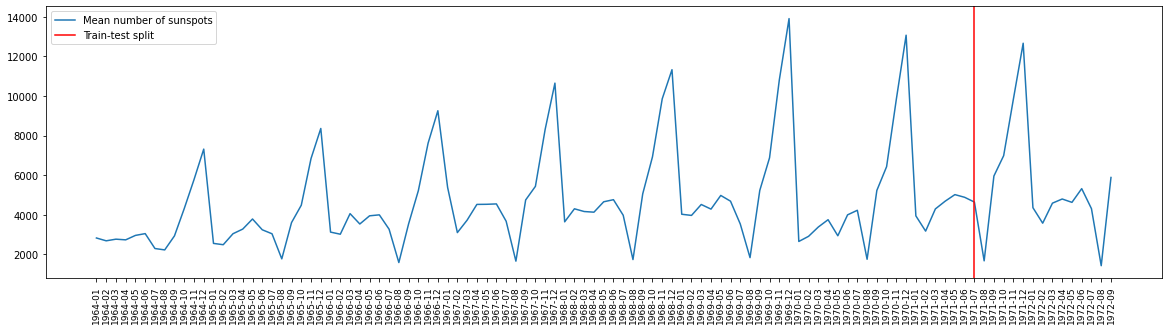

In [ ]:
ts1[['Sales']].plot(figsize=(20, 5));
plt.xticks(ticks = np.arange(len(ts1)), labels = ts1['Month'], rotation='vertical', fontsize=9)
plt.axvline(len(ts1)-15, color = 'red')
plt.legend(['Mean number of sunspots', 'Train-test split']);

In [ ]:
ts2_train.tail()

,date,meantemp
1457,2016-12-28,17.217391
1458,2016-12-29,15.238095
1459,2016-12-30,14.095238
1460,2016-12-31,15.052632
1461,2017-01-01,10.000000


In [ ]:
ts2_test.head()

,date,meantemp
0,2017-01-01,15.913043
1,2017-01-02,18.500000
2,2017-01-03,17.111111
3,2017-01-04,18.700000
4,2017-01-05,18.388889


Тут я принял волевое решение выкинуть последнее наблюдение из ```train```, так как даты совпадают с первым наблюдением в ```test```, а температура мне кажется более реалистичной в ```test```

In [ ]:
ts2_train = ts2_train[:-1]

In [ ]:
ts2_train.tail()

,date,meantemp
1456,2016-12-27,16.850000
1457,2016-12-28,17.217391
1458,2016-12-29,15.238095
1459,2016-12-30,14.095238
1460,2016-12-31,15.052632


In [ ]:
ts2 = ts2_train.append(ts2_test, ignore_index=True, sort=False)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


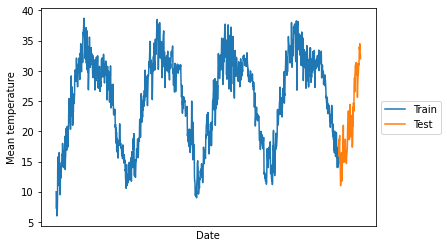

In [ ]:
plt.plot(ts2_train['date'], ts2_train[['meantemp']])
plt.plot(ts2_test['date'], ts2_test[['meantemp']])
plt.xlabel('Date')
plt.ylabel('Mean temperature')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.legend(['Train', 'Test'], bbox_to_anchor=(1,0.5), loc = 'center left');

In [ ]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))
plt.plot(..., ...)
plt.xlabel('Time')
plt.show()

In [ ]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

В данных по продажам шампанского есть повторяющиеся колебания в течение года (с локальными шоками спроса в декабре):



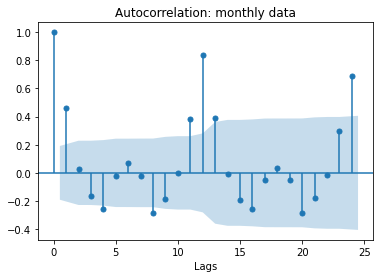

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(ts1[['Sales']], lags=24)
plt.xlabel('Lags')
plt.title('Autocorrelation: monthly data')
plt.show();

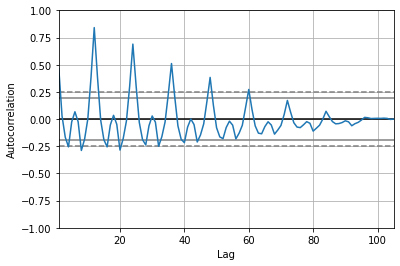

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts1['Sales']);

В суточных данных по температуре есть явно выраженная сезонность в течение года:

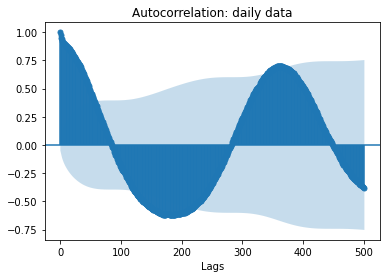

In [ ]:
sm.graphics.tsa.plot_acf(ts2['meantemp'], lags=500)
plt.xlabel('Lags')
plt.title('Autocorrelation: daily data')
plt.show();

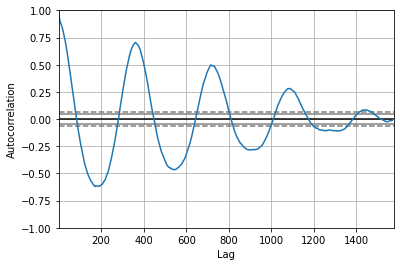

In [ ]:
autocorrelation_plot(ts2['meantemp']);

In [ ]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

Выведем повторяющиеся паттерны в сезонности:

In [ ]:
ts11 = ts1.copy()

In [ ]:
ts11.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [ ]:
ts11['month'] = ts11['Month'].str.split('-').str[1]

In [ ]:
ts11.head()

,Month,Sales,month
0,1964-01,2815,01
1,1964-02,2672,02
2,1964-03,2755,03
3,1964-04,2721,04
4,1964-05,2946,05


Мне было лень придумывать, как убрать линию, соединяющую декабрь с январем следующего года, поэтому представим что  прямых линий нет:

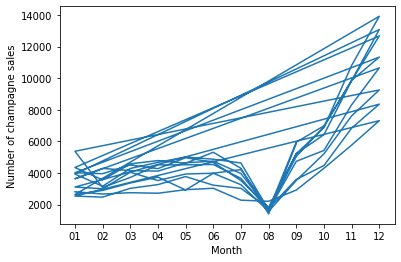

In [ ]:
plt.plot(ts11['month'],ts11['Sales'])
plt.xlabel('Month')
plt.ylabel('Number of champagne sales');

И для суточных данных:

In [ ]:
ts22 = ts2.copy()

In [ ]:
ts22.head()

,date,meantemp,prednaive1
0,2013-01-01,10.000000,NaN
1,2013-01-02,7.400000,NaN
2,2013-01-03,7.166667,NaN
3,2013-01-04,8.666667,NaN
4,2013-01-05,6.000000,NaN


In [ ]:
ts22['day'] = np.NaN

In [ ]:
for i in range(len(ts22)):
    period = pd.Period(ts22['date'][i], freq='D')
    ts22['day'][i] = period.dayofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
ts22.tail()

,date,meantemp,prednaive1,day
1570,2017-04-20,34.500,NaN,110.0
1571,2017-04-21,34.250,NaN,111.0
1572,2017-04-22,32.900,NaN,112.0
1573,2017-04-23,32.875,NaN,113.0
1574,2017-04-24,32.000,NaN,114.0


Тут есть пара некрасивых линий из-за високосного 2016 года, но в остальном выглядит вот так:

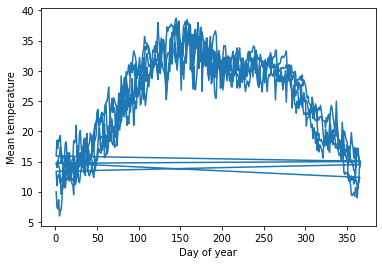

In [ ]:
plt.plot(ts22['day'],ts22['meantemp'])
plt.xlabel('Day of year')
plt.ylabel('Mean temperature');

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error as MAE

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts1_train['Sales'])

NaiveForecaster()

In [ ]:
fh = ForecastingHorizon(ts1_test.index, is_relative=False)

ts1_pred1 = forecaster.predict(fh)

In [ ]:
MAE(ts1_test['Sales'], ts1_pred1)

1824.4

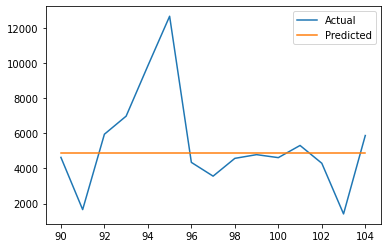

In [ ]:
plt.plot(ts1_test['Sales'])
plt.plot(ts1_pred1)
plt.legend(['Actual', 'Predicted']);

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp = 12)
forecaster.fit(ts1_train['Sales'])

NaiveForecaster(sp=12)

In [ ]:
ts1_pred = forecaster.predict(fh)

In [ ]:
MAE(ts1_test['Sales'], ts1_pred)

353.8666666666667

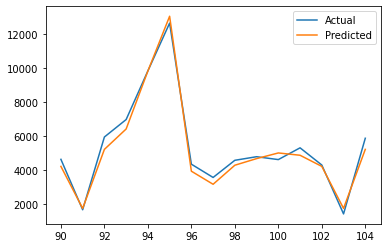

In [ ]:
plt.plot(ts1_test['Sales'])
plt.plot(ts1_pred)
plt.legend(['Actual', 'Predicted']);

Логарифм по сути ничего не поменяет, но MAE снизится, так как меньше размерности

In [ ]:
forecaster.fit(np.log(ts1_train['Sales']))
fh = ForecastingHorizon(ts1_test.index, is_relative=False)
ts1_logpred = forecaster.predict(fh)
MAE(np.log(ts1_test['Sales']), ts1_logpred)

0.08054041310637063

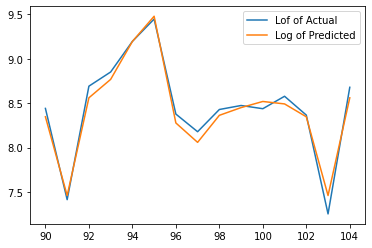

In [ ]:
plt.plot(np.log(ts1_test['Sales']))
plt.plot(ts1_logpred)
plt.legend(['Lof of Actual', 'Log of Predicted']);

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ваш код обучения моделей здесь

In [ ]:
arima = ARIMA(order=(1, 1, 0),
              seasonal_order=(1, 0, 0, 12))
arima.fit(ts1_train['Sales'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12))

In [ ]:
ts1_pred_a = arima.predict(fh)
MAE(ts1_test['Sales'], ts1_pred_a)

1267.7639269835397

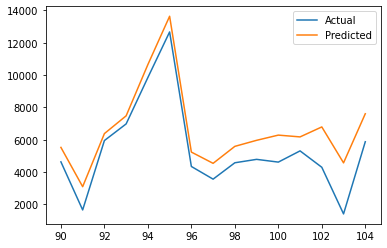

In [ ]:
plt.plot(ts1_test['Sales'])
plt.plot(ts1_pred_a)
plt.legend(['Actual', 'Predicted']);

In [ ]:
aarima = AutoARIMA(sp=12)
aarima.fit(ts1_train['Sales'])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


AutoARIMA(sp=12)

In [ ]:
ts1_pred_aa = aarima.predict(fh)
MAE(ts1_test['Sales'], ts1_pred_aa)

359.6958758637475

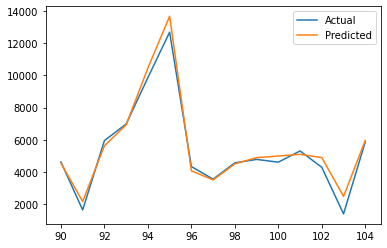

In [ ]:
plt.plot(ts1_test['Sales'])
plt.plot(ts1_pred_aa)
plt.legend(['Actual', 'Predicted']);

In [ ]:
# посчитайте метрики на test

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

# ваш код обучения моделей здесь

In [ ]:
dlt = DLTFull(
    response_col='Sales', 
    date_col='Month',
    seasonality=12,
)

Здесь есть проблема, так как наблюдений маловато для оценки модели

In [ ]:
dlt.fit(ts1_train)

In [ ]:
predicted_df = dlt.predict(ts1_test)
predicted_df.head()

,Month,prediction_5,prediction,prediction_95
0,1971-07,3214.635062,4332.472023,5425.003234
1,1971-08,561.215260,2063.753005,3423.639350
2,1971-09,4182.215726,5712.843288,6778.729641
3,1971-10,5374.690663,6916.533857,8299.319213
4,1971-11,9132.027391,10474.164686,11940.520762


In [ ]:
predicted_df.tail()

,Month,prediction_5,prediction,prediction_95
10,1972-05,3202.619542,5199.870167,6421.282792
11,1972-06,3319.029796,4874.805850,6560.471891
12,1972-07,2708.849880,4540.613971,5994.882233
13,1972-08,-176.567518,2253.248104,3650.938470
14,1972-09,3712.341867,6085.457140,7818.633344


Доверительный интервал слишком широкий, так как наблюдений не слишком много

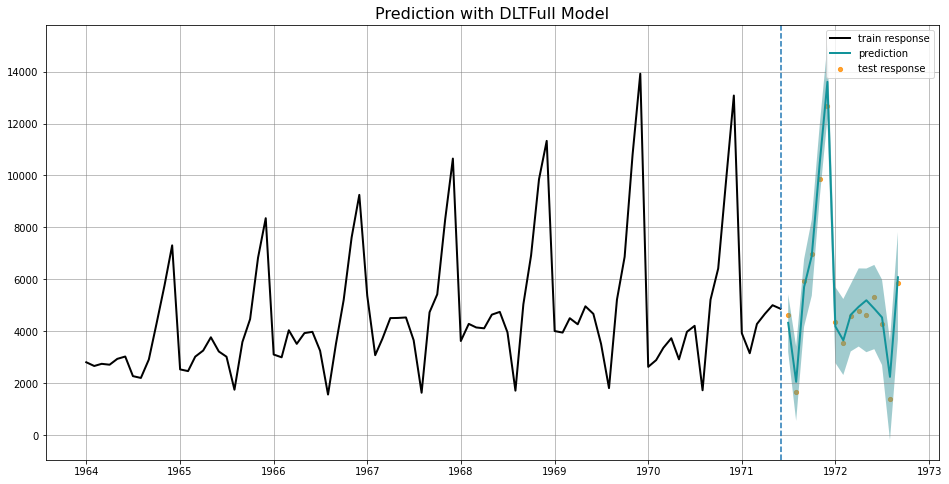

In [ ]:
from orbit.diagnostics.plot import plot_predicted_data

plot_predicted_data(
    training_actual_df=ts1_train, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=ts1_test, insample_line=True, 
    title='Prediction with DLTFull Model'
);

In [ ]:
MAE(ts1_test['Sales'], predicted_df['prediction'])

356.7409592450307

In [ ]:
lgt = LGTFull(
    response_col='Sales', 
    date_col='Month',
    seasonality=12,
)

In [ ]:
lgt.fit(ts1_train)

In [ ]:
predicted_df = lgt.predict(ts1_test)

In [ ]:
predicted_df.tail()

,Month,prediction_5,prediction,prediction_95
10,1972-05,3400.560568,5137.697915,6289.781225
11,1972-06,3803.753154,4961.332708,6449.510230
12,1972-07,2883.770447,4530.930336,6503.421780
13,1972-08,383.305523,2481.665940,4637.845538
14,1972-09,3671.415305,5723.320532,8123.020547


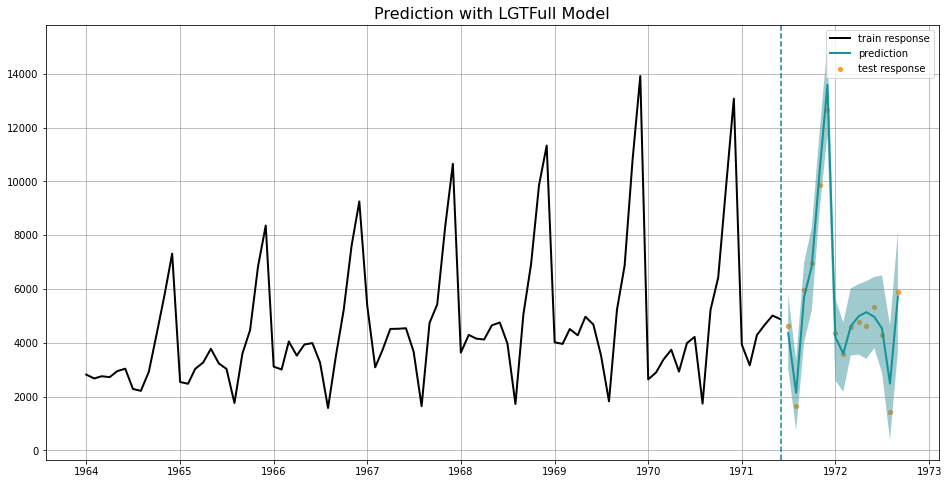

In [ ]:
plot_predicted_data(training_actual_df=ts1_train, predicted_df=predicted_df,
                    date_col=lgt.date_col, actual_col=lgt.response_col,
                    test_actual_df=ts1_test, insample_line=True, 
                    title='Prediction with LGTFull Model');

Модель LGT ненамного лучше справилась с описанием данных:

In [ ]:
MAE(ts1_test['Sales'], predicted_df['prediction'])

356.16611270944765

In [ ]:
# посчитайте метрики на test

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

In [ ]:
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
forecaster.fit(ts1_train['Sales'])

ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='add')

In [ ]:
predictETS = forecaster.predict(fh)
MAE(ts1_test['Sales'], predictETS)

354.35505894459743

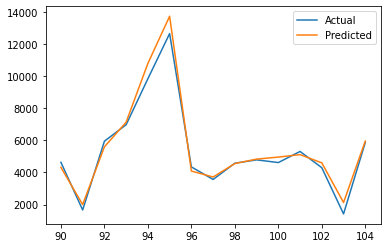

In [ ]:
plt.plot(ts1_test['Sales'])
plt.plot(predictETS)
plt.legend(['Actual', 'Predicted']);

In [ ]:
forecaster = AutoETS(auto=True, sp=12)
forecaster.fit(ts1_train['Sales'].astype('float64'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


AutoETS(auto=True, sp=12)

In [ ]:
predictAETS = forecaster.predict(fh)

In [ ]:
MAE(ts1_test['Sales'], predictAETS)

307.9010483705255

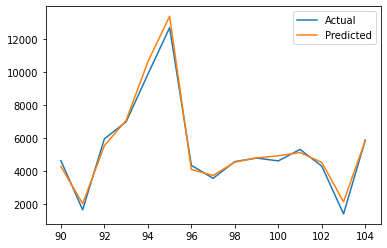

In [ ]:
plt.plot(ts1_test['Sales'])
plt.plot(predictAETS)
plt.legend(['Actual', 'Predicted']);

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания

По метрике MAE лучшей получилась autoETS модель, метод return_pred_ints для нее пока не разработан, поэтому будет просто график предсказанных значений:



In [ ]:
ts1_test['Pred'] = preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
ts1_test.head()

,Month,Sales,Pred
90,1971-07,4633,4281.705805
91,1971-08,1659,2032.102537
92,1971-09,5951,5539.181125
93,1971-10,6981,7066.034958
94,1971-11,9851,10607.663626


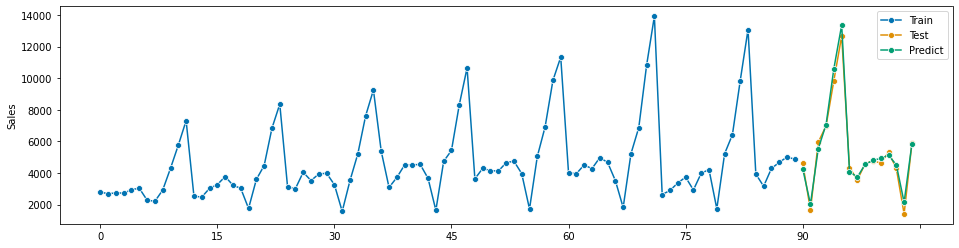

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(ts1_train['Sales'], ts1_test['Sales'], ts1_test['Pred'],
            labels=["Train", "Test", "Predict"],
            #pred_int = True
            );

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts2_train['meantemp'])
# ваш код обучения моделей здесь

NaiveForecaster()

In [ ]:
ts2_train.tail()

,date,meantemp
1456,2016-12-27,16.850000
1457,2016-12-28,17.217391
1458,2016-12-29,15.238095
1459,2016-12-30,14.095238
1460,2016-12-31,15.052632


In [ ]:
len(ts2_test)

114

In [ ]:
ts2_test = ts2_test.set_index([np.arange(1461,1575)])

In [ ]:
ts2_test.head()

,date,meantemp
1461,2017-01-01,15.913043
1462,2017-01-02,18.500000
1463,2017-01-03,17.111111
1464,2017-01-04,18.700000
1465,2017-01-05,18.388889


In [ ]:
fh = np.arange(len(ts2_test['meantemp']))

In [ ]:
ts2_pred = forecaster.predict(fh)
MAE(ts2_test['meantemp'], ts2_pred)

11.668757590588353

In [ ]:
ts2_test['prednaive1'] = ts2_pred

In [ ]:
ts2_test.head()

,date,meantemp,prednaive1
1461,2017-01-01,15.913043,15.052632
1462,2017-01-02,18.500000,10.000000
1463,2017-01-03,17.111111,10.000000
1464,2017-01-04,18.700000,10.000000
1465,2017-01-05,18.388889,10.000000


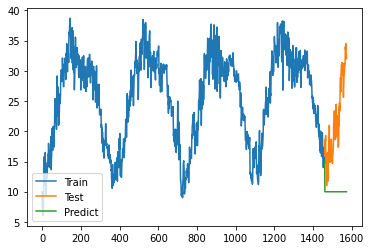

In [ ]:
plt.plot(ts2_train['meantemp'])
plt.plot(ts2_test['meantemp'])
plt.plot(ts2_test['prednaive1'])
plt.legend(['Train', 'Test', 'Predict']);

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=365)
forecaster.fit(ts2_train['meantemp'])

NaiveForecaster(sp=365)

In [ ]:
ts2_pred2 = forecaster.predict(fh)
MAE(ts2_test['meantemp'], ts2_pred2)

2.616887072354993

In [ ]:
ts2_test['prednaive2'] = ts2_pred2

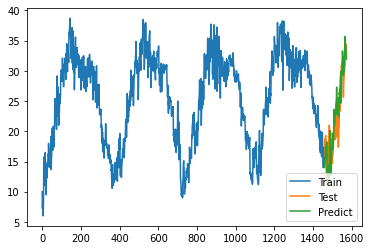

In [ ]:
plt.plot(ts2_train['meantemp'])
plt.plot(ts2_test['meantemp'])
plt.plot(ts2_test['prednaive2'])
plt.legend(['Train', 'Test', 'Predict']);

In [ ]:
# посчитайте метрики на test

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь

In [ ]:
ktr = KTRLiteMAP(
    response_col='meantemp', 
    date_col='date',
    seasonality=365,
)

In [ ]:
ktr.fit(ts2_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54eae5ecf2d426f33baa7b746b329122 NOW.


In [ ]:
pred_ktr = ktr.predict(ts2_test)
pred_ktr.head()

,date,prediction_5,prediction,prediction_95
0,2017-01-01,3.016762,15.481837,27.736028
1,2017-01-02,3.196311,15.433223,27.874636
2,2017-01-03,2.751586,15.390397,27.833303
3,2017-01-04,2.666975,15.353409,27.634816
4,2017-01-05,2.912261,15.322305,27.763353


In [ ]:
MAE(ts2_test['meantemp'], pred_ktr['prediction'])

2.060503192750361

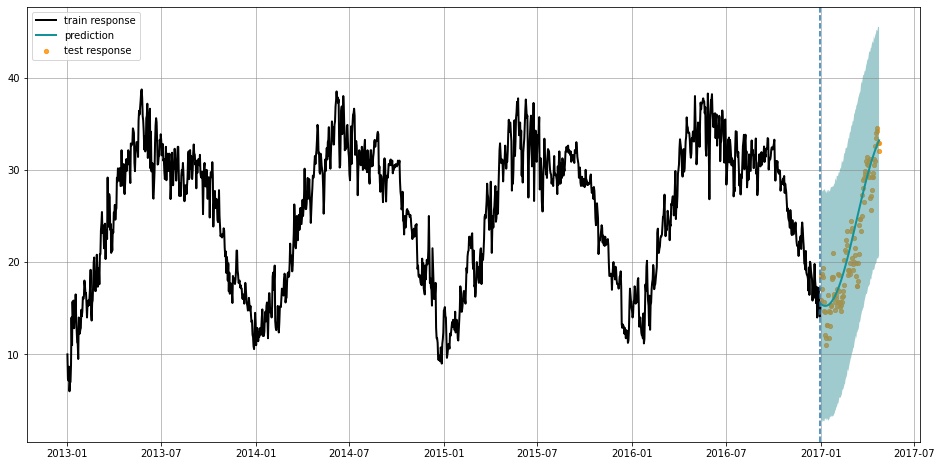

In [ ]:
plot_predicted_data(training_actual_df=ts2_train, predicted_df=pred_ktr,
                        date_col=ktr.date_col, actual_col=ktr.response_col,
                        test_actual_df=ts2_test, insample_line=True);

In [ ]:
# посчитайте метрики на test

### Phophet (1 балл).



In [ ]:
from prophet import Prophet

# ваш код обучения моделей здесь

In [ ]:
ts2_train = ts2_train.rename(columns={'date':'ds', 'meantemp':'y'})
ts2_test = ts2_test.rename(columns={'date':'ds', 'meantemp':'y'})
ts2_test = ts2_test[['ds', 'y']]

In [ ]:
m = Prophet()
m.fit(ts2_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
len(ts2_test['ds'])

114

In [ ]:
future = m.make_future_dataframe(periods=114)
future.tail()

,ds
1570,2017-04-20
1571,2017-04-21
1572,2017-04-22
1573,2017-04-23
1574,2017-04-24


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1570,2017-04-20,33.012348,30.606324,35.655971
1571,2017-04-21,33.156664,30.711361,35.687024
1572,2017-04-22,33.238704,30.547251,35.801216
1573,2017-04-23,33.307295,30.624363,35.935639
1574,2017-04-24,33.636982,30.983707,36.216001


Зачем-то он построил два графика

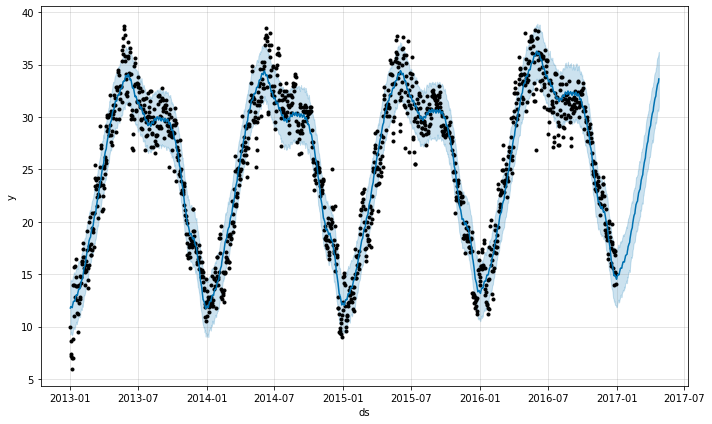

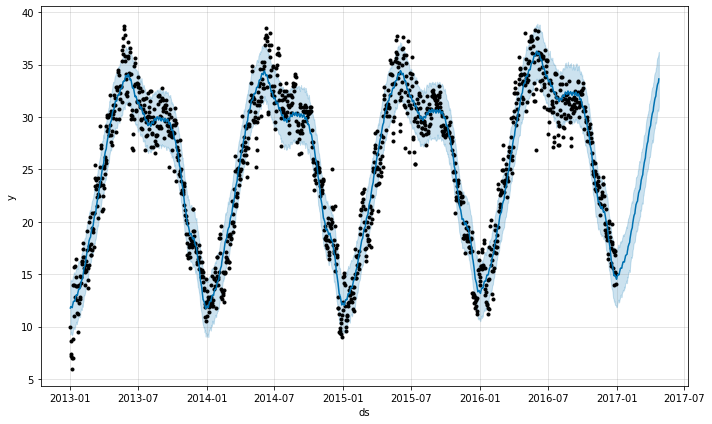

In [ ]:
m.plot(forecast)

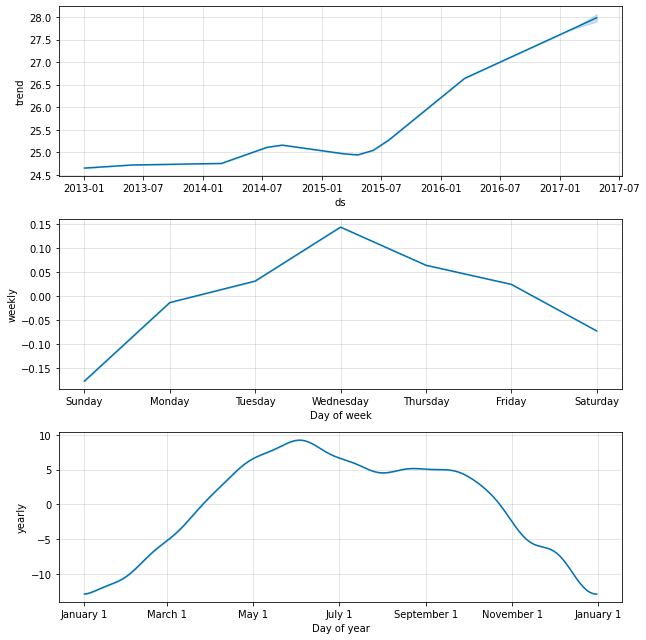

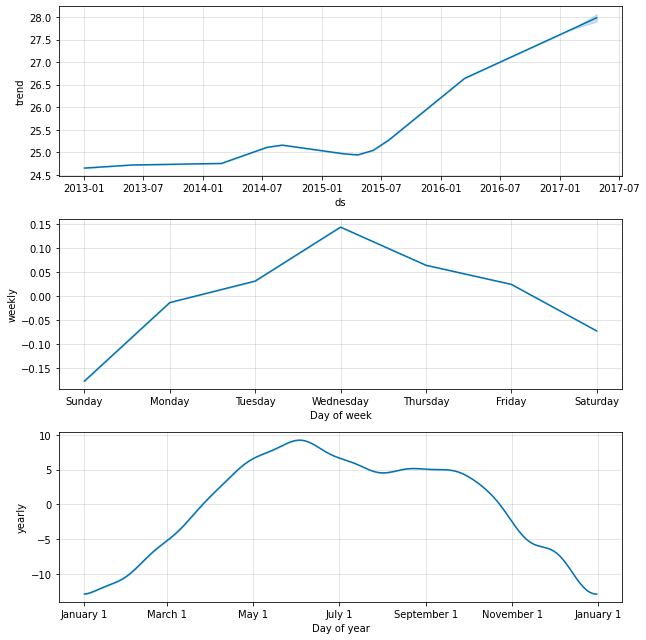

In [ ]:
m.plot_components(forecast)

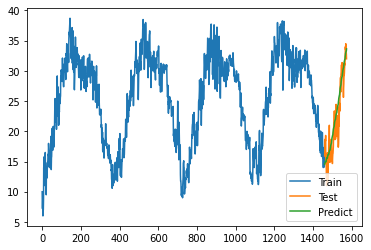

In [ ]:
plt.plot(ts2_train['y'])
plt.plot(ts2_test['y'])
plt.plot(forecast[-114:]['yhat'])
#plt.plot(forecast[-114:]['yhat_lower'])
#plt.plot(forecast[-114:]['yhat_upper'])
plt.legend(['Train', 'Test', 'Predict']);

In [ ]:
MAE(ts2_test['y'], forecast[-114:]['yhat'])

2.221174431752287

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [ ]:
# нарисуйте пресказания

По метрике MAE лучшей моделью оказался KTR, так что продублируем график:

In [ ]:
ts2_train = ts2_train.rename(columns={'ds':'date', 'y':'meantemp'})
ts2_test = ts2_test.rename(columns={'ds':'date', 'y':'meantemp'})

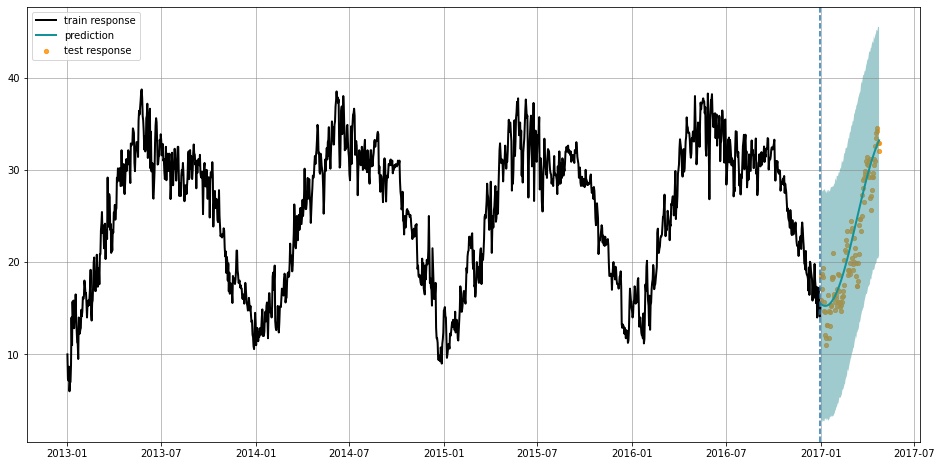

In [ ]:
plot_predicted_data(training_actual_df=ts2_train, predicted_df=pred_ktr,
                        date_col=ktr.date_col, actual_col=ktr.response_col,
                        test_actual_df=ts2_test, insample_line=True);

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [ ]:
# ваш код модели на STAN и её обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте пресказания